In [1]:
#!/usr/bin/env python
# coding: utf-8

#@author : Debanjana

import argparse
import torch
import time
import numpy as np
import math
import random
import pickle as pkl

from sklearn.metrics import precision_recall_fscore_support

manualSeed = 1525
start = time.time()

np.random.seed(manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)
torch.cuda.manual_seed_all(manualSeed)

torch.backends.cudnn.enabled = False 
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [61]:
def batch_generator(X, X2, y, batch_size=64, return_idx=False):
    
    for offset in range(0, X.shape[0], batch_size):
        #print(len(X), X.shape, X2.shape)
        #print('---------------------------------------------------')
        #print('offset', offset)
        y = np.asarray(y)
        batch_X2_len=X2[offset:offset+batch_size]!=0
        batch_X_len=np.sum(X[offset:offset+batch_size]!=0, axis=1)
        batch_idx2=batch_X2_len.argsort()
        batch_idx=batch_X_len.argsort()[::-1]
        #print(batch_idx, batch) #[::-1]
        batch_X_len=batch_X_len[batch_idx]
        batch_X2_len=batch_X2_len[batch_idx2]
        batch_X_mask=(X[offset:offset+batch_size]!=0)[batch_idx].astype(np.uint8)
        batch_X=X[offset:offset+batch_size][batch_idx]
        batch_X2=X2[offset:offset+batch_size][batch_idx2]
        batch_y=y[offset:offset+batch_size][batch_idx]
        batch_X = torch.autograd.Variable(torch.from_numpy(batch_X).long() )
        batch_X2 = torch.autograd.Variable(torch.from_numpy(batch_X2).long() )
        batch_X_mask=torch.autograd.Variable(torch.from_numpy(batch_X_mask).long() )
        batch_y = torch.autograd.Variable(torch.from_numpy(batch_y).long() )
        #print(batch_X, batch_y)
        if len(batch_y.size() )==2 :
            try:
                batch_y=torch.nn.utils.rnn.pack_padded_sequence(batch_y, batch_X2_len, batch_first=True)
            except:
                continue
        if return_idx: 
            #in testing, need to sort back.
            yield (batch_X, batch_y, batch_X_len, batch_X_mask, batch_idx)
        else:
            yield (batch_X, batch_X2, batch_y, batch_X2_len, batch_X_mask)

In [3]:
def seeder(manualSeed):
    np.random.seed(manualSeed)
    random.seed(manualSeed)
    torch.manual_seed(manualSeed)
    torch.cuda.manual_seed(manualSeed)
    torch.cuda.manual_seed_all(manualSeed)
    
    torch.backends.cudnn.enabled = False 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [65]:
class Model(torch.nn.Module):
    def __init__(self, ft_emb, tweet_emb, num_classes=2, dropout=0.5):
        super(Model, self).__init__()
        
        manualSeed = 1525
        #print('shapes : ',gen_emb.shape[0], gen_emb.shape[1] )
        seeder(manualSeed)
        
        self.ft_embedding = torch.nn.Embedding(ft_emb.shape[0], ft_emb.shape[1]) #no. of emb x emb dim
        
        self.ft_embedding.weight=torch.nn.Parameter(torch.from_numpy(ft_emb), requires_grad=False)
        
        self.tweet_embedding = torch.nn.Embedding(tweet_emb.shape[0], tweet_emb.shape[1]) #no. of emb x emb dim
        
        self.tweet_embedding.weight=torch.nn.Parameter(torch.from_numpy(tweet_emb), requires_grad=False)
                
        seeder(manualSeed)
        
        self.linear_features=torch.nn.Linear(ft_emb.shape[1], ft_emb.shape[1] ) 
        
        seeder(manualSeed)
        
        self.lstm = torch.nn.LSTM(input_size = tweet_emb.shape[1], hidden_size = 128, num_layers = 1, bidirectional = True)
        
        seeder(manualSeed)
                
        self.dropout=torch.nn.Dropout(dropout)
        
        seeder(manualSeed)
        
        self.linear_final=torch.nn.Linear(256 + ft_emb.shape[1], num_classes) 
        
            
    def forward(self, x, x2,  x_len, x_mask, x_tag=None, testing=False):
        #print('gen',self.gen_embedding(x).shape, type(self.gen_embedding(x)))
        seeder(manualSeed)
        
        ft_emb = self.ft_embedding(x2).type(torch.FloatTensor) #ft = link score + bias + class_wts
        
        ft_emb = torch.nn.functional.relu(self.linear_features(ft_emb))
        
        twt_emb = self.tweet_embedding(x).type(torch.FloatTensor)
        
        #print(ft_emb.shape, twt_emb.shape)
        
        seeder(manualSeed)
        
        ft_emb = self.linear_features(ft_emb)
        
        seeder(manualSeed)
        
        twt_emb, _ = self.lstm(twt_emb)
        
        twt_emb = torch.nn.functional.relu(twt_emb)
        
        pool = torch.nn.MaxPool1d(twt_emb.shape[1], stride=1)
        
        twt_emb = pool(twt_emb.transpose(1,2))
        #print(ft_emb.shape, twt_emb.shape)
        
        twt_emb = self.dropout(twt_emb)
        ft_emb.unsqueeze_(-1)
        ft_emb = ft_emb.expand(ft_emb.shape[0],ft_emb.shape[1],1)
        
        #print(ft_emb.shape, twt_emb.shape)
        
        emb = torch.cat((ft_emb, twt_emb), dim=1).transpose(1,2)
        
        #print(emb.shape)
        
        seeder(manualSeed)
        
        x_logit=self.linear_final(emb)
        
        #print(x_logit.shape)
        
        seeder(manualSeed)

        if testing:
            x_logit=x_logit.transpose(2, 0)
            score=torch.nn.functional.log_softmax(x_logit).transpose(2, 0)
        else:
            x_logit=torch.nn.utils.rnn.pack_padded_sequence(x_logit, x_len, batch_first=True)   #removes padding
            score=torch.nn.functional.nll_loss(torch.nn.functional.log_softmax(x_logit.data), x_tag.data)
        
        return score


In [5]:
def valid_loss(model, valid_X, valid_X2, valid_y):
    model.eval()
    losses=[]
    for batch in batch_generator(valid_X, valid_X2, valid_y):
        batch_valid_X, batch_valid_X2, batch_valid_y, batch_valid_X_len, batch_valid_X_mask=batch
        loss=model(batch_valid_X, batch_valid_X2, batch_valid_X_len, batch_valid_X_mask, batch_valid_y)
        #print(loss)
        losses.append(loss.item())
    model.train()
    return sum(losses)/len(losses)

In [59]:
def train(train_X, train_X2, train_y, valid_X, valid_X2, valid_y, model, model_fn, optimizer, parameters, epochs=200, batch_size=64):
    best_loss=float("inf") 
    valid_history=[]
    train_history=[]
    for epoch in range(epochs):
        
        for batch in batch_generator(train_X, train_X2, train_y, batch_size):
            batch_train_X, batch_train_X2, batch_train_y, batch_train_X_len, batch_train_X_mask=batch
            loss=model(batch_train_X, batch_train_X2, batch_train_X_len, batch_train_X_mask, batch_train_y) #going to forward directly by matching parameters?
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm(parameters, 1.)
            optimizer.step()
        loss=valid_loss(model, train_X, train_X2, train_y)
        train_history.append(loss)
        print('epoch ', epoch, ' trained..loss = ',loss )
        loss=valid_loss(model, valid_X, valid_X2, valid_y)
        print('epoch ', epoch, ' validated..loss = ',loss )
        valid_history.append(loss)        
        if loss<best_loss:
            best_loss=loss
            torch.save(model, model_fn)
        shuffle_idx=np.random.permutation(len(train_X) )
        train_X=train_X[shuffle_idx]
        train_X2=train_X2[shuffle_idx]
        train_y=train_y[shuffle_idx]
    model=torch.load(model_fn) 
    return train_history, valid_history

In [7]:
def test(model, test_X, test_X2, batch_size=64, crf=False):
    
    pred_y=np.zeros((test_X.shape[0], 1), np.int16)
    model.eval()
    
    for offset in range(0, test_X.shape[0], batch_size):
        
        batch_test_X_len=np.sum(test_X[offset:offset+batch_size]!=0, axis=1)
        batch_test_X2_len=test_X2[offset:offset+batch_size]!=0
        batch_idx=batch_test_X_len.argsort()[::-1]
        batch_idx2=batch_test_X2_len.argsort()
        batch_test_X_len=batch_test_X_len[batch_idx]
        batch_test_X2_len=batch_test_X2_len[batch_idx2]
        batch_test_X_mask=(test_X[offset:offset+batch_size]!=0)[batch_idx].astype(np.uint8)
        batch_test_X=test_X[offset:offset+batch_size][batch_idx]
        batch_test_X2=test_X2[offset:offset+batch_size][batch_idx2]
        batch_test_X_mask=torch.autograd.Variable(torch.from_numpy(batch_test_X_mask).long() )
        batch_test_X = torch.autograd.Variable(torch.from_numpy(batch_test_X).long() )
        batch_test_X2 = torch.autograd.Variable(torch.from_numpy(batch_test_X2).long() )
        batch_pred_y=model(batch_test_X, batch_test_X2, batch_test_X_len, batch_test_X_mask, testing=True)
        r_idx=batch_idx.argsort()
        batch_pred_y=batch_pred_y.data.cpu().numpy().argmax(axis=2)[r_idx]
        pred_y[offset:offset+batch_size,:batch_pred_y.shape[1]]=batch_pred_y
    
    model.train()
    assert len(pred_y)==len(test_X)
    
    return pred_y


In [38]:
def data_formatter(tweets, train_idx, sent_idx, corpus_len=0):
    
    sent_list1 = []
    for i, sent in enumerate(tweets):
        sents = [train_idx[word + '_' + str(i +corpus_len)] for word in sent.split()]
        sent_list1.append(sents)
    
    #padding
    MAX = max([len(sent) for sent in sent_list1])
    print('Max length of tweet = ', MAX)
    
    for i in range(len(sent_list1)):
        words = np.zeros(MAX)
        words[:len(sent_list1[i])] = sent_list1[i]
        sent_list1[i] = words
            
                    
    sent_list2 = [sent_idx[sent] for i, sent in enumerate(tweets)] 
    
    print(np.array(sent_list1).shape, np.array(sent_list2).shape)
    
    return np.array(sent_list1), np.array(sent_list2)

In [70]:
def run(data_dir, model_dir, runs, epochs, lr, dropout, batch_size=128):
    
    with open(data_dir+"covid_embeddings_en.pickle", "rb") as pkl_in:
        feat_emb = pkl.load(pkl_in)      #link score + class wt + bias ft
        
    with open('./resources/tweet_word_emb_en.pickle', 'rb') as pkl_in:
        tweet_word_emb = pkl.load(pkl_in)
    
    print(feat_emb.shape)
    
    feat_emb = np.insert(feat_emb, 0, np.ones(len(feat_emb[0])), axis = 0)  #inserting embedding for pad
    tweet_word_emb = np.insert(tweet_word_emb, 0, np.ones(len(tweet_word_emb[0])), axis = 0) #inserting embedding for pad
    
    with open('./resources/tweets_preprocessed_multi.pickle', 'rb') as pkl_in:
        train_data = pkl.load(pkl_in)
        valid_data = pkl.load(pkl_in)
        test_data = pkl.load(pkl_in) 

        train_tags = pkl.load(pkl_in)
        valid_tags = pkl.load(pkl_in)
        test_tags = pkl.load(pkl_in)
        
    with open(data_dir+"multi_word_idx_en.pickle", "rb") as pkl_in:
        word_idx = pkl.load(pkl_in)
        
    with open(data_dir+"multi_sent_idx_en.pickle", "rb") as pkl_in:
        sent_idx = pkl.load(pkl_in)

   
    print('test data sample : ', test_data[0])
    print('Length of train and test data : ', len(train_data), len(test_data))
    print('Length of train and test tags : ', len(train_tags), len(test_tags))
    print('--------------------------------------------------------------------')
    
    test_X, test_y = test_data, np.asarray(test_tags)
    train_X, train_y = train_data, np.asarray(train_tags)
    valid_X_true, valid_y = valid_data, np.asarray(valid_tags)
    

    print('valid data sample : ', valid_X_true[0])
    
    valid_X_1, valid_X_2 = data_formatter(valid_X_true, word_idx, sent_idx, len(train_X))
    train_X_1, train_X_2 = data_formatter(train_X, word_idx, sent_idx, 0)
    test_X_1, test_X_2 = data_formatter(test_X, word_idx, sent_idx, len(train_data)+len(valid_X_true))
    
    
    for r in range(runs):
        print('-------------------------------------------------------------------------------')
        print(r)
        
        model=Model(feat_emb, tweet_word_emb, num_classes=2, dropout=dropout)
        #model.cuda()
        
        parameters = [p for p in model.parameters() if p.requires_grad]
        optimizer=torch.optim.Adam(parameters, lr=lr)
        train_history, valid_history=train(train_X_1, train_X_2, train_y, valid_X_1, valid_X_2, valid_y, model, model_dir+str(r), optimizer, parameters, epochs, batch_size)
        
        model=torch.load(model_dir+str(r))
        pred=test(model, test_X_1, test_X_2, batch_size, crf=False)
    
        print(precision_recall_fscore_support(test_y, pred, average='macro'))
        print(precision_recall_fscore_support(test_y, pred, average='micro'))
        print(precision_recall_fscore_support(test_y, pred, average='weighted'))

    return train_y, test_y, train_history, valid_history


In [76]:
if __name__ == "__main__":
    print('testing code')
    train_y, true, th, vh = run('./resources/','./resources/model_meta', 1, 50, 0.0001, 0.4, 16)

testing code
(504, 3)
test data sample :  a state of emergency has been declared for la city and county due to confirmed cases of coronavirus . angelenos need to be prepared , but not panicked . listen to the advice of experts . make sure you ' re following @cdcgov and @la public health for the latest info and recommendations . <link>
Length of train and test data :  403 51
Length of train and test tags :  403 51
--------------------------------------------------------------------
valid data sample :  safety always comes first . do not panic and stay safe .  corona alert <link>
Max length of tweet =  71
(50, 71) (50,)
Max length of tweet =  125
(403, 125) (403,)
Max length of tweet =  73
(51, 73) (51,)
-------------------------------------------------------------------------------
0


/home/debanjana_ibm/anaconda3/envs/covidfake/lib/python3.6/site-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/debanjana_ibm/anaconda3/envs/covidfake/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if sys.path[0] == '':


epoch  0  trained..loss =  0.6469668320247105
epoch  0  validated..loss =  0.642158567905426
epoch  1  trained..loss =  0.6445313010896955
epoch  1  validated..loss =  0.6244661211967468
epoch  2  trained..loss =  0.6182243142809186
epoch  2  validated..loss =  0.6156518459320068
epoch  3  trained..loss =  0.6116836581911359
epoch  3  validated..loss =  0.6071416139602661
epoch  4  trained..loss =  0.6084710870470319
epoch  4  validated..loss =  0.5993238687515259
epoch  5  trained..loss =  0.5909407649721418
epoch  5  validated..loss =  0.5924621820449829
epoch  6  trained..loss =  0.5794044733047485
epoch  6  validated..loss =  0.588848352432251
epoch  7  trained..loss =  0.5758888295718602
epoch  7  validated..loss =  0.5809667110443115
epoch  8  trained..loss =  0.5555441294397626
epoch  8  validated..loss =  0.5718463659286499
epoch  9  trained..loss =  0.5508480497768947
epoch  9  validated..loss =  0.5651542544364929
epoch  10  trained..loss =  0.5350904975618634
epoch  10  vali

/home/debanjana_ibm/anaconda3/envs/covidfake/lib/python3.6/site-packages/ipykernel_launcher.py:81: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(0.8168981481481481, 0.8134157509157509, 0.8149597238204833, None)
(0.8208955223880597, 0.8208955223880597, 0.8208955223880597, None)
(0.8202805417357657, 0.8208955223880597, 0.8204008725074283, None)
English
(0.7580357142857144, 0.75, 0.7536231884057971, None)
(0.7843137254901961, 0.7843137254901961, 0.7843137254901961, None)
(0.7815476190476192, 0.7843137254901961, 0.7826086956521741, None)
English with text fts
(0.7352941176470589, 0.7352941176470589, 0.7352941176470589, None)
(0.7647058823529411, 0.7647058823529411, 0.7647058823529412, None)
(0.7647058823529411, 0.7647058823529411, 0.7647058823529411, None)
w/o link
(0.7361111111111112, 0.7205882352941176, 0.7267857142857144, None)
(0.7647058823529411, 0.7647058823529411, 0.7647058823529412, None)
(0.7592592592592592, 0.7647058823529411, 0.7607142857142858, None)
w/o bias


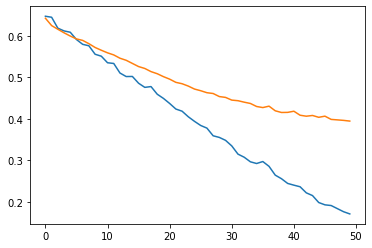

In [77]:
import matplotlib.pyplot as plt

plt.plot(range(len(th)), th)
plt.plot(range(len(th)), vh)
plt.savefig('loss_graph.png')
plt.show()

In [ ]:
with open("./resources/tweet_embeddings.pickle", "rb") as pkl_in:
    feat_emb = pkl.load(pkl_in)
    
feat_emb=np.asarray([emb.detach().numpy() for emb in feat_emb])
feat_emb.shape